In [2]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt 
from matplotlib import rcParams 

## Read SDSS DR7 stars with 0.2 < g-r < 0.4 (data used in Tomography papers)  

In [3]:
colnames = ['X', 'Y', 'Z', 'vX', 'vY', 'vZ', 'Zph', 'Mr', 'D', 'fDerr',  
            'ra', 'dec', 'run', 'Ar', 'u', 'g', 'r', 'i', 'z',  
            'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'errX', 'errY', 'errZ',  
            'ZphErr', 'fDerr2', 'pmL', 'pmB']  
# notes: 
# XYZ and their errors are in pc (derived quantities)
# vX, vY and vZ in km/s (derived quantities)
# Zph is photometric metallicity estimate (as in Ivezic et al. 2008)
# Mr is photometrically estimated absolute magnitude in the r band
# D is distance in pc, fDerr is its fractional uncertainty in percent
# ra/dec in degrees, pmL/pmB in mas/yr (data)
# run is SDSS observing run identifier
# Ar is the SFD extinction in the r band
# ugriz and errors is the SDSS psf photometry 
# errX, errY and errX are uncertainties for XYZ
# ZphErr is estimated uncertainty for photometric metallicity Zph
# fDerr2 is an auxiliary irrelevant quantity 
# pmL and pmB are POSS vs. SDSS proper motions in galactic coordinates (mas/yr)

if (0):
    sdss = Table.read('XYZpm_DR7_FGblue.dat', format='ascii', names=colnames)
else:
    # developed code using XYZpm_DR7_FGblue_1percent.dat  
    # a 1% subsample produced with
    # cat XYZpm_DR7_FGblue.dat | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .01) print $0}' > XYZpm_DR7_FGblue_1percent.dat
    sdss = Table.read('XYZpm_DR7_FGblue_1percent.dat', format='ascii', names=colnames)

Text(0, 0.5, 'Dec (deg)')

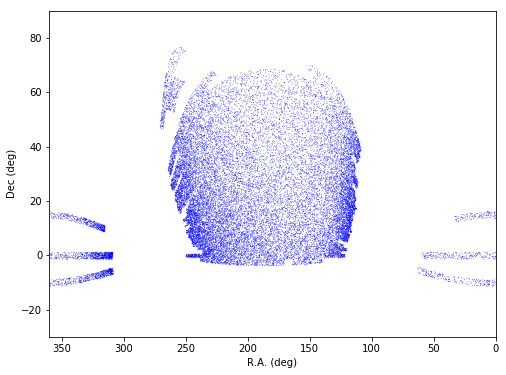

In [4]:
gr = sdss['g'] - sdss['r']
ra = sdss['ra']
dec = sdss['dec']
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(ra, dec, s=0.01, c='blue') 
ax.set_xlim(360,0)
ax.set_ylim(-30,90)
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')

## Tools for computing derived quantities, such as absolute magnitude and distance

In [5]:
def getMainSequenceAbsMag(gi,FeH): 
    """Get absolute magnitude for main sequence stars using eqs. 2, 5, and 7 from
       Ivezic et al. 2008 (ApJ, 684, 287)"""

    # valid for 0.2 < g-i < 4.0 
    Mr0 = -5.06 + 14.32*gi - 12.97*gi**2 + 6.127*gi**3 - 1.267*gi**4 + 0.0967*gi**5
    # offset for metallicity, valid for -2.5 < FeH < 0.2
    Mr = Mr0 + 4.50 - 1.11*FeH - 0.18*FeH**2
    return Mr

def getMainSequenceDistanceKpc(gi,FeH,r): 
    """Get stellar distance in kpc"""
    
    # valid for 0.2 < g-i < 4.0 and -2.5 < FeH < 0.2
    Mr = getMainSequenceAbsMag(gi,FeH)
    # distance in kpc
    Dkpc = 0.01 * 10**(0.2*(r-Mr))
    return Dkpc

def getMainSequenceAppMagforDistanceKpc(gi,FeH,Dkpc): 
    """Get apparent mag array for g-i array, given FeH and Dkpc"""
    # valid for 0.2 < g-i < 4.0 and -2.5 < FeH < 0.2
    Mr = getMainSequenceAbsMag(gi,FeH)
    return Mr + 5*np.log10(100*Dkpc)  

def getPhotomMetallicityBond2010(ug,gr):
    """Get stellar photometric metallicity from the SDSS u, g and r magnitudes
       using eq.A1 from Bond et al. 2010 (ApJ, 716, 1):
       [Fe/H]=A+Bx+Cy+Dxy+Ex2+Fy2+Gx2y+Hxy2+Ix3+Jy3
       with x = (u-g) and y = (g-r), and the best-fit coefficients 
       (A-J) = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20).
       This expression if valid only for g-r<0.6; for redder stars uses [Fe/H] = -0.6.
       Beyond the limits -2.5 and 0.5, use the limits. Add Gaussian noise with rms=0.1"""

    # aux variables
    x = ug
    y = gr
    xy = x*y
    x2 = x*x
    y2 = y*y
    x2y = x*x*y
    xy2 = x*y*y
    y3 = y*y*y

    A = -13.13  
    B =  14.09
    C =  28.04
    D =  -5.51
    E =  -5.90
    F = -58.68
    G =   9.14
    H = -20.61
    I =  58.20
    FeH = A + B*x + C*y + D*xy + E*x2 + F*y2 + G*x2y + H*xy2 + I*y3 
    # add Gaussian noise (rms=0.1 dex) 
    np.random.seed(666) 
    b = np.random.randn(FeH.shape[0])  # Gaussian
    FeH = FeH + 0.1*b
    FeH[gr>0.6] = -0.6
    FeH[FeH < -2.5] = -2.5
    FeH[FeH > 0.5] = 0.5
    return FeH    

## More analysis tools

In [63]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = 0 
            sigGbin[i] = 0 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin


def plotCoded2DmapRAbins(x, y, z, RA, xMin, xMax, yMin, yMax, nBin, xLabel, yLabel, cLabel, median=True):

    rcParams['ytick.labelsize'] = 15
    rcParams['xtick.labelsize'] = 15
    rcParams['axes.labelsize'] = 20
    rcParams['axes.linewidth'] = 2
    rcParams['font.size'] = 15
    rcParams['axes.titlesize'] = 18

    def selectRAbin(x, y, z, RA, RAmin, RAmax): 
        xB = x[(RA>RAmin)&(RA<RAmax)]
        yB = y[(RA>RAmin)&(RA<RAmax)]
        zB = z[(RA>RAmin)&(RA<RAmax)]
        return xB, yB, zB 

    # define plotting space 
    fig = plt.figure(figsize=(15,7)) 
    fig.subplots_adjust(hspace=0.35, top=1, bottom=0., left=0.12, right=0.93)
    # location of the colorbar in Figure units 
    bottom, height =  1.14, 0.02 
            
    # calculate the 2D statistics 
    if (median):
        statsName = 'median'   
        cLlabel = 'median ' + cLabel
    else:
        statsName = 'rms' 
        cLlabel = 'rms for ' + cLabel
         
    RAmin = np.zeros(6) 
    RAmin[0] = 40
    RAmin[1] = 20
    RAmin[2] = 0
    RAmin[3] = 340
    RAmin[4] = 320
    RAmin[5] = 300


    for i in range(0,6):
        ax = plt.subplot(2,3,i+1) 
        ax.set_xlabel(xLabel)
        ax.set_ylabel(" ")
        if ((i==0) or (i==3)): 
            ax.set_ylabel(yLabel)
        title = RAmin[i] 
        ax.set_title(title)
        plt.xlim([xMin,xMax])
        plt.ylim([yMax,yMin])
        ax.plot([xMin, xMax], [0, 0], lw=1, c='black')
        ax.plot([0, 0], [yMin, yMax], lw=1, c='black')
        # extract the 2D statistic,  and location of bin edges 
        xB, yB, zB = selectRAbin(x, y, z, RA, RAmin[i], RAmin[i]+20.0)
        # print('i:', i, np.size(xB), np.size(yB), np.size(zB))
        stats =  binned_statistic_2d(xB, yB, zB, statistic=statsName, bins=nBin)
        H, xedges, yedges= stats[0].T , stats[1], stats[2]

        # span the grid from bin edges 
        X_, Y_ = np.meshgrid(xedges, yedges)
        cmap = 'viridis'
        cmap = 'jet'


        # plot the image 
        image = ax.pcolormesh(X_, Y_, H, cmap=cmap)

        if (i==0): 
            # extract the left corner and width of colorbar from axis - 
            # works well for multiple axes since location of 
            # new axis must be in figure units 
            l,b,w,h = ax.get_position().bounds
            cax = fig.add_axes([l,bottom,w,height])
            # plot the colorbar 
            plt.colorbar(mappable = image, cax = cax, orientation='horizontal', label=cLlabel)
            
        if (0):
            giGrid = np.linspace(0.0,4.5,100)
            FeH = -1.5
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,0.3)
            ax.plot(giGrid, rD)
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,1.0)
            ax.plot(giGrid, rD)
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,3.0)
            ax.plot(giGrid, rD)
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,10.0)
            ax.plot(giGrid, rD)
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,30.0)
            ax.plot(giGrid, rD)


    plt.savefig('Fig_Coded2DmapRAbins.png', bbox_inches='tight', dpi=100)

## Compute derived quantities

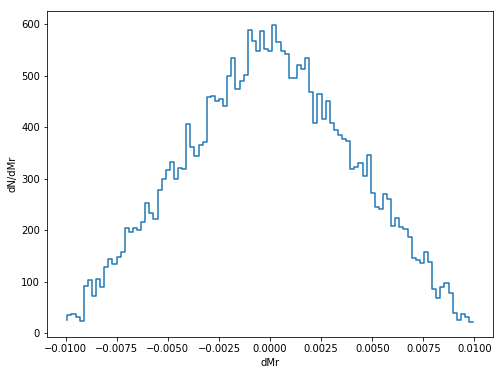

In [9]:
## are the latest photometric distances consistent with what's in that file? 
Dfile = sdss['D'] 
MrFile = sdss['Mr']
MrTest = sdss['r'] - 5*np.log10(Dfile) + 5 
dMr = MrTest - MrFile 
# plot dMr histogram
fig,ax = plt.subplots(1,1,figsize=(8,6))
hist, bins = np.histogram(dMr, bins=100)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   
ax.set_xlabel('dMr')
ax.set_ylabel('dN/dMr')
plt.show()

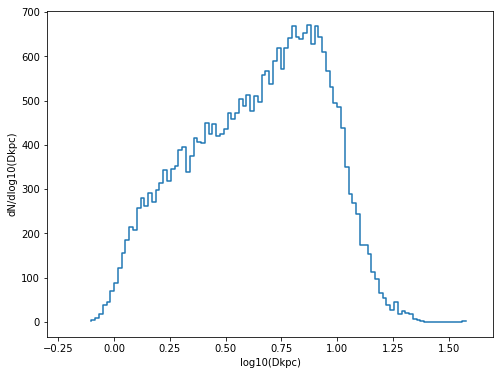

In [11]:
xx = np.log10(Dfile/1000)
fig,ax = plt.subplots(1,1,figsize=(8,6))
hist, bins = np.histogram(xx, bins=100)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   
ax.set_xlabel('log10(Dkpc)')
ax.set_ylabel('dN/dlog10(Dkpc)')
ax.set_xlim(-0.3, 1.7)
plt.show()

### Conclusions:
- Mr agrees to within 0.01 mag with getMainSequenceAbsMag
- distance range is from about 1 kpc to 15 kpc

### Let's now focus on Stripe 82 

In [25]:
## use the full catalog here...
sdssFull = Table.read('XYZpm_DR7_FGblue.dat', format='ascii', names=colnames)
raFull = sdssFull['ra']  
decFull = sdssFull['dec'] 
raWFull = np.where(raFull > 180, raFull-360, raFull)
np.size(raWFull)

2951349

In [26]:
## use the full catalog here...
s82 = sdssFull[(np.abs(decFull)<1.3)&(np.abs(raWFull)<70)]
ra = s82['ra'] 
dec = s82['dec'] 
raW = np.where(ra > 180, ra-360, ra)
np.size(raW)

109249

Text(0, 0.5, 'Dec (deg)')

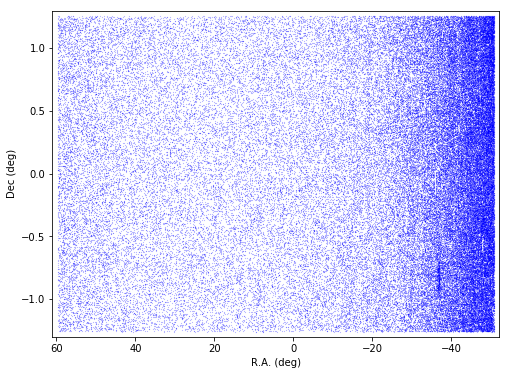

In [31]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raW, dec, s=0.01, c='blue') 
ax.set_xlim(61,-52)
ax.set_ylim(-1.3,1.3)
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')

Text(0, 0.5, 'D (kpc)')

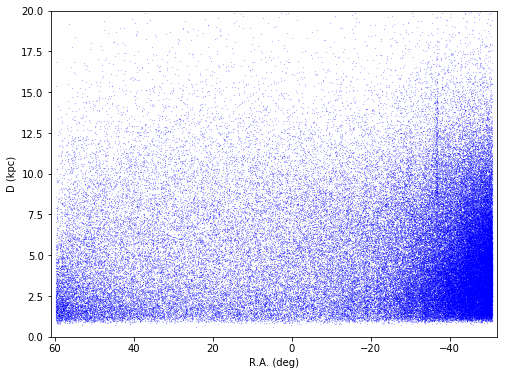

In [32]:
Dkpc = s82['D']/1000.0
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raW, Dkpc, s=0.01, c='blue') 
ax.set_xlim(61,-52)
ax.set_ylim(0, 20)
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('D (kpc)')

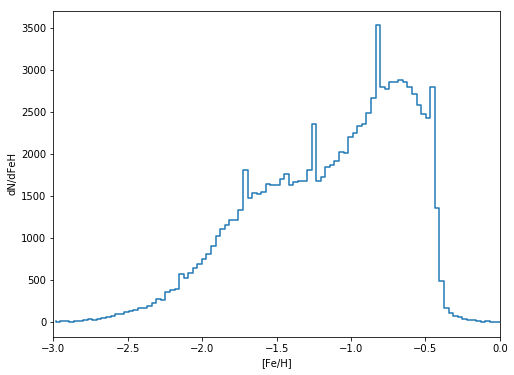

In [34]:
FeH = s82['Zph']
fig,ax = plt.subplots(1,1,figsize=(8,6))
hist, bins = np.histogram(FeH, bins=100)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('dN/dFeH')
ax.set_xlim(-3, 0)
plt.show()

Text(0, 0.5, 'D (kpc)')

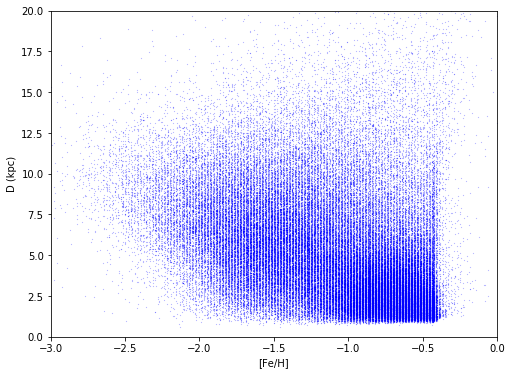

In [35]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(FeH, Dkpc, s=0.01, c='blue') 
ax.set_xlim(-3,0)
ax.set_ylim(0, 20)
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('D (kpc)')

In [37]:
pmL = s82['pmL']  
pmB = s82['pmB']  

In [49]:
# define distance slices
s82D1 = s82[Dkpc<2.5]
s82D2 = s82[(Dkpc>2.5)&(Dkpc<5)]
s82D3 = s82[(Dkpc>5)&(Dkpc<10)]

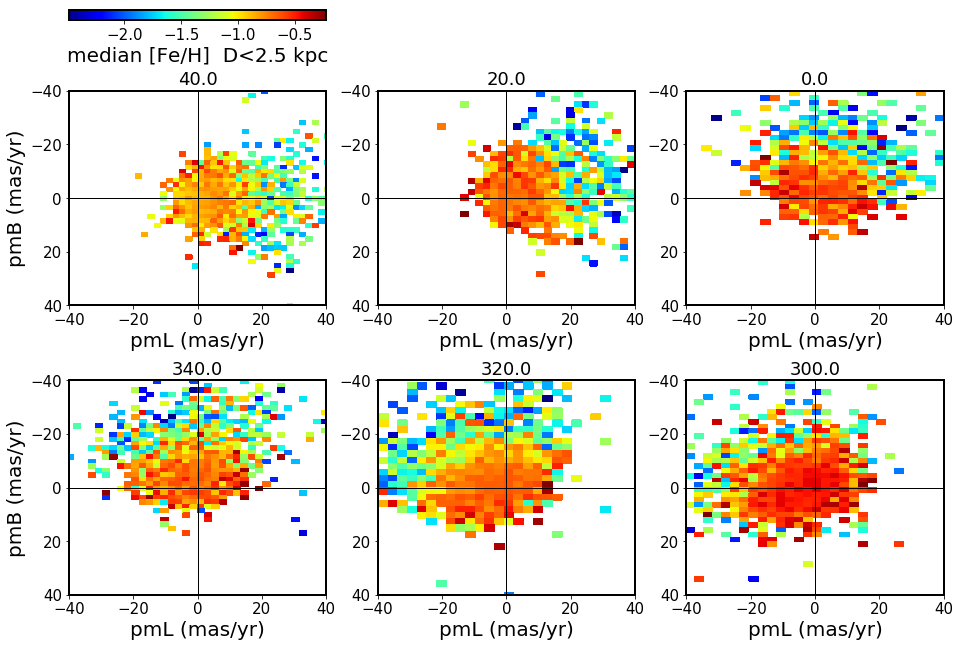

In [64]:
Dra = s82D1['ra']
DFeH = s82D1['Zph']
DpmL = s82D1['pmL']  
DpmB = s82D1['pmB']  
plotCoded2DmapRAbins(DpmL, DpmB, DFeH, Dra, -40, 40, -40, 40, 50, 'pmL (mas/yr)', 'pmB (mas/yr)', '[Fe/H]  D<2.5 kpc')

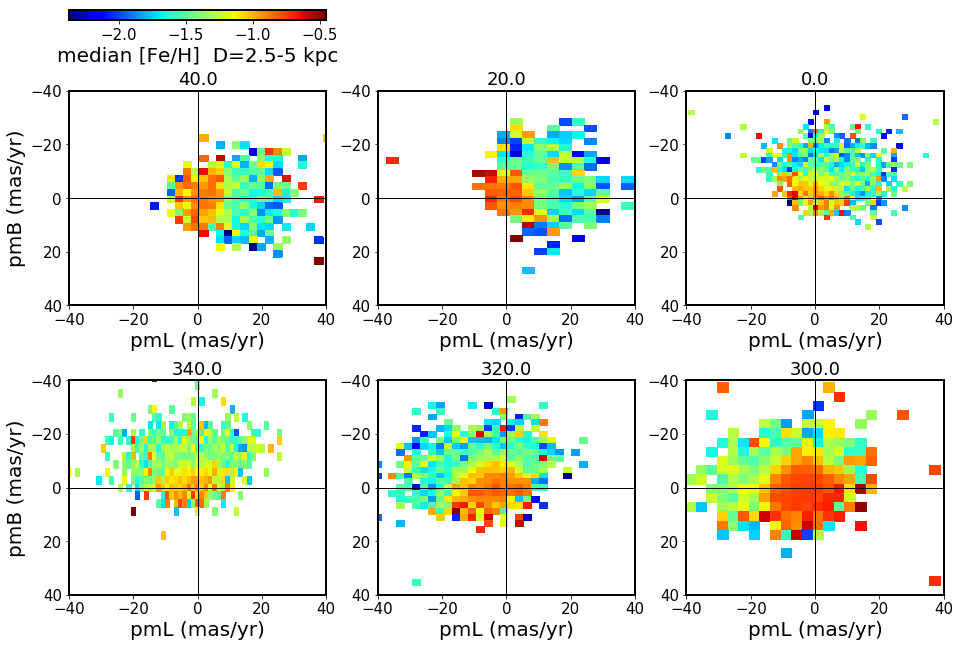

In [65]:
Dra = s82D2['ra']
DFeH = s82D2['Zph']
DpmL = s82D2['pmL']  
DpmB = s82D2['pmB']  
plotCoded2DmapRAbins(DpmL, DpmB, DFeH, Dra, -40, 40, -40, 40, 50, 'pmL (mas/yr)', 'pmB (mas/yr)', '[Fe/H]  D=2.5-5 kpc')

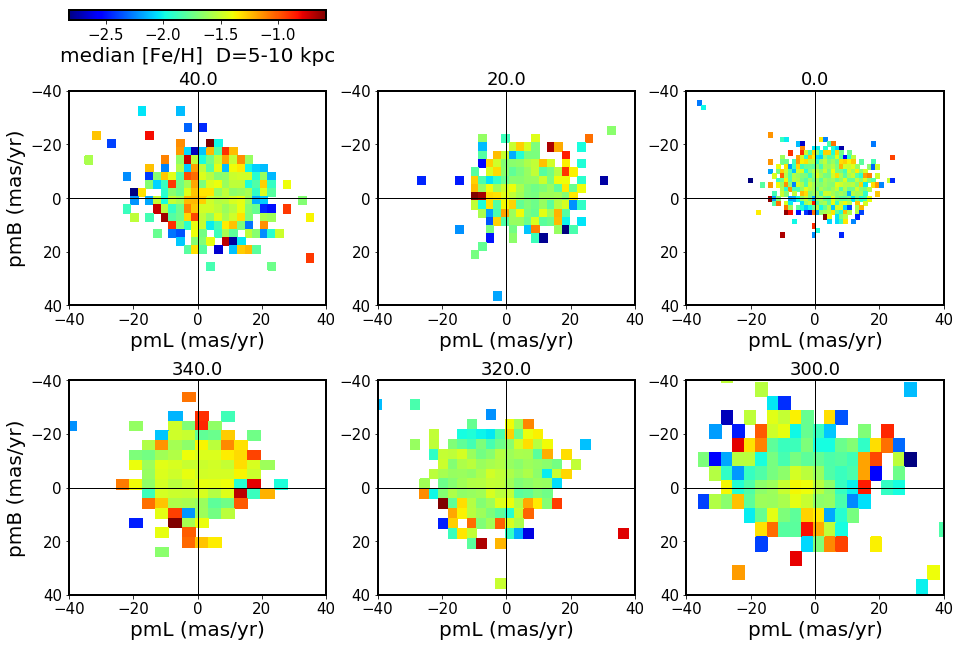

In [66]:
Dra = s82D3['ra']
DFeH = s82D3['Zph']
DpmL = s82D3['pmL']  
DpmB = s82D3['pmB']  
plotCoded2DmapRAbins(DpmL, DpmB, DFeH, Dra, -40, 40, -40, 40, 50, 'pmL (mas/yr)', 'pmB (mas/yr)', '[Fe/H]  D=5-10 kpc')